En este script se predice las posiciones siguientes del conjunto de datos PETS-S2L1, 
usando como salida las posiciones absolutas.

In [1]:
import os
import pickle
import numpy 
import pandas as pd
#import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *
from matplotlib import pyplot

from scipy. ndimage import filters
import pandas as pd
import os
from keras.models import Model, Sequential, save_model, load_model
import math
from sklearn.metrics import mean_squared_error

import random
from sklearn.preprocessing import MinMaxScaler
import h5py
import tensorflow as tf


Using TensorFlow backend.


In [5]:
import os 
import pickle
import numpy as np
import random

def preprocess(data_dirs, data_file,name):
    # all_ped_data would be a dictionary with mapping from each ped to their
    # trajectories given by matrix 3 x numPoints with each column
    # in the order x, y, frameId
    # Pedestrians from all datasets are combined
    # Dataset pedestrian indices are stored in dataset_indices
    all_ped_data={}
    dataset_indices=[]
    current_ped = 0
    # For each dataset
    for directory in data_dirs:
        # Define the path to its respective csv file
        #PETS2009-S2L1-mmundo.csv
        #'PETS09-S2L1.txt'
        file_path = os.path.join(directory,name )

        # Cargar datos desde el archivo csv
        # Los datos son una matriz 4x numTrajPoints
        
        
        data = np.genfromtxt(file_path, delimiter=',')
       
        
        # Obtenga el numero de peatones en el conjunto de datos actual
        uni=np.unique(data[:,1])    
        numPeds=np.size(np.unique(data[:,1]))
        
        print("El numero de peatones en"+ directory+" es "+str(numPeds))
       
        # Para cada peaton en el conjunto de datos
        for ped in range(1, numPeds+1):
            #Son los datos de la persona ped
            traj = data[ data[:, 1] == ped]
            #Esta como (x,y,frame_Id)
            traj = traj[:, [2,3,0]]
            
            #Esta como [[x,...],[y,...],[Frame_Id,..]]
            traj=[list(traj[:,0]),list(traj[:,1]),list(traj[:,2])]
            all_ped_data[current_ped + ped] = np.array(traj)

        # Current dataset done
        dataset_indices.append(current_ped+numPeds)
        current_ped += numPeds

    # Los datos completos son una tupla de todos los datos de peatones y los indices de datos del conjunto de datos.
    complete_data = (all_ped_data, dataset_indices)
    # Almacena los datos completos en el archivo pickle
    f = open(data_file, "wb")
    pickle.dump(complete_data, f, protocol=2)
    f.close()
    return complete_data

In [14]:
def load_preprocessed(data_file,seq_length_obs,batch_size):
    
    # cargar los datos
    f = open(data_file, "rb")
    raw_data = pickle.load(f)
    f.close()

    # Obtengo los peatones
    all_ped_data =raw_data[0]
 
    #all_ped_data es el vector {[[],[],[]],...,[[],[],[]]} tantos como pedestrian hayan
    # No usamos dataset_indices por ahora
    # dataset_indices = self.raw_data[1]

    # Construimos data con secuencias(o trayectorias) del largo than seq_length_obs
    data = []
    counter = 0

    # para cada peaton en data
    for ped in all_ped_data:
        
        #ped es un numero entero y va de 1 hasta la cantidad total de pedestrian
        # Extract his trajectory
        traj = all_ped_data[ped]
           
        #print(traj.shape)
        # If the length of the trajectory is greater than seq_length (+2 as we need both source and target data)
        #solo se toman las trajectorias de longitud mayor a seq_length+2
        if traj.shape[1] >= (seq_length_obs+1):
            # TODO: (Improve) Store only the (x,y) coordinates for now
            
            #print(traj[[0, 1], :].shape)
            data.append(traj[[0, 1], :].T)
            #print(traj[[0, 1], :].T)
            # Number of batches this datapoint is worth
            #print(traj.shape[1] )
            #print(int(traj.shape[1] / ((seq_length_obs+1))))
            counter += int(traj.shape[1] / ((seq_length_obs+1)))
        
    # Calculate the number of batches (each of batch_size) in the data
    #counter tiene la cantidad de bloques de 8 pasos
        
    num_batches = int(counter /batch_size)
    #cada bache tiene batch_size conjuntos donde cada conjunto tiene datos de length+2
    return data,num_batches

In [15]:

data_dirs = ['../data1/pets']
datasets=[0]
#data_dirs=['../data1/ucy/univ','../data1/ucy/zara/zara02','../data1/eth/hotel','../data1/ucy/zara/zara01']

#prueba=['../data1/eth/univ']
#datasets=[0,1,2,3]
used_data_dirs = [data_dirs[x] for x in datasets]
#Directorio de datos donde reside el archivo pickle preprocesado
data_dir = '../data1'

#Defina la ruta del archivo en el que deben almacenarse los datos.
data_file = os.path.join(data_dir, "datos_limpios_.cpkl")


# Para pets si se usa pixel_pos.csv es el de framerate 7.5
# Para pets si se usa pixel_pos_2.csv es el de framerate 3.75
name ='pixel_pos.csv'


#print(used_data_dirs)
data = preprocess(used_data_dirs, data_file,name)
datos,numero = load_preprocessed(data_file,12,1)
print("El numero de muestras es de "+str(numero))

El numero de peatones en../data1/pets es 19
El numero de muestras es de 349


In [16]:
def secuencia(seq_length_obs,data):  
    tamano=int(len(data))
    
    X,Y=[],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs
    #lon=data.shape[0]-seq_length_obs-seq_length_pred
        for i in range(0,lon):
            a = traj[i:(i +seq_length_obs ), :]
            X.append(a)
            b = traj[i +seq_length_obs,:]
            Y.append(b)
    return np.array(X),np.array(Y)

## Visualización de los Datos

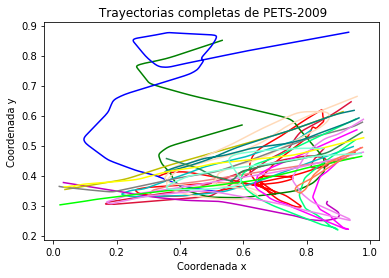

In [17]:
# plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
import random
color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]

for i in range(len(datos)):
    cpu = random.choice(range(17))
    pintar = plt.plot(datos[i][:,0],datos[i][:,1],color=color_names[i])
plt.title(" Trayectorias completas de PETS-2009") 
plt.xlabel("Coordenada x")   
plt.ylabel("Coordenada y") 

#plt.savefig("trayectorias.jpg")
plt.show() 


## Como se divide los conjuntos de datos

In [18]:
longitud=len(datos)
ind = range(longitud)

lista = []
for i in range(0,longitud,4):
    lista.append(ind[i:i+4])
print(lista)

combinacion=[(0,1,2,3,4),(0,1,2,4,3),(0,1,3,4,2),(0,2,3,4,1),(1,2,3,4,0)]

def conjunto_datos(combinacion,lista,datos):
    conjunto_entrenamiento = []
    for i in range(len(combinacion)-1):
       # print(i)
        for j in lista[combinacion[i]]:
        #    print(j)
            conjunto_entrenamiento.append(datos[j])
    conjunto_prueba=[]
    for i in lista[combinacion[4]]:
        #print(shape(datos[i]))
        conjunto_prueba.append(datos[i])
    
    return conjunto_entrenamiento,conjunto_prueba

[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15], [16, 17, 18]]


In [19]:
train1,test1 = conjunto_datos(combinacion[0],lista,datos)
#vali1=[test1[0]]
train2,test2 = conjunto_datos(combinacion[1],lista,datos)
#vali2=[test2[0]]
train3,test3 = conjunto_datos(combinacion[2],lista,datos)
train4,test4 = conjunto_datos(combinacion[3],lista,datos)
train5,test5 = conjunto_datos(combinacion[4],lista,datos)


In [ ]:
length_obs = 8
trainX,trainY = secuencia(length_obs,train1)
#valiX,valiY = secuencia(length_obs,vali2)

In [ ]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],trainX.shape[2]))
#valiX= numpy.reshape(valiX, (valiX.shape[0], valiX.shape[1],valiX.shape[2]))

In [ ]:
data_shape = trainX.shape[1:]
print(data_shape)
import numpy as np
np.shape(trainX)

## Diseño de la red

In [ ]:
from keras.models import Sequential
from keras import optimizers
#from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dense
from keras.layers import LSTM
#from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from datetime import datetime
from keras.utils import plot_model



if 'model' in globals(): del model
model = None
model = Sequential()
model.add(LSTM(9, return_sequences=True, input_shape=data_shape, name='lstm1'))
model.add(LSTM(9, name='lstm2'))
model.add(Dense(2))

In [ ]:
model.summary()

In [ ]:
#validation_data=(vali_obs, vali_pred),
opt = optimizers.RMSprop(lr = 0.006, decay=1e-2)
model.compile(optimizer=opt, loss='logcosh',metrics=['mse'])
history= model.fit(trainX, trainY, epochs=100, batch_size=16, verbose=2)
#plot_model(model, show_shapes=True, to_file='modelo.png')

In [ ]:
history_dict= history.history
history_dict.keys()

In [ ]:
acc = history.history['mean_squared_error']
#val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

# figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training mse')
#plt.plot(epochs, val_acc, 'g', label='Validation mse')
plt.title('Training mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Modelos de PETS con framerate de 7.5 frames por segundo

In [ ]:
#model.save('lstm-xy1.h5')

In [ ]:
#model.save('lstm-xy2.h5')

In [ ]:
#model.save('lstm-xy3.h5')

In [ ]:
#model.save('lstm-xy4.h5')

In [ ]:
#model.save('lstm-xy5.h5')

# Modelos de PETS con framerate de 3 frames por segundo

In [ ]:
#model.save('lstm-xy1-simplicado.h5')

In [ ]:
#model.save('lstm-xy2-simplicado.h5')

In [ ]:
#model.save('lstm-xy3-simplicado.h5')

In [ ]:
#model.save('lstm-xy4-simplificado.h5')

In [ ]:
#model.save('lstm-xy5-simplicado.h5')

# SE carga el modelo con el cual se predice

In [20]:
modelxy = load_model('lstm-xy3.h5')

W0326 14:03:20.828846 140273044969216 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0326 14:03:20.844208 140273044969216 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0326 14:03:20.846770 140273044969216 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0326 14:03:21.190483 140273044969216 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_se

## Errores para medir las trayectorias predichas

In [21]:
def error_promedio(predicted_traj, true_traj, observed_length):
    
    error = np.zeros(len(true_traj) - observed_length)
    # PARA CADA PUNTO EN LA TRAYECTORIA PREDICHA
    for i in range(observed_length, len(true_traj)):
        # The predicted position
        pred_pos = predicted_traj[i]
        # The true position
        true_pos = true_traj[i]

        # The euclidean distance is the error
        error[i-observed_length] = np.linalg.norm(true_pos - pred_pos)

    # Return the mean error
    return np.mean(error)


In [22]:
def error_desplazamiento_final(predicted_traj, true_traj):
    tam = len(predicted_traj)
    return np.linalg.norm(predicted_traj[tam-1]-true_traj[tam-1])

In [23]:
#esta funcion construye secuencias con solo la parte observada y secuencias completa
# es decir secuencia de longitud obs+pred

def secuencia_pred(seq_length_obs,data,seq_length_pred):
    
    tamano = int(len(data))
    X,Y_true = [],[]
    # se recorre todo los datos de test
    for j in range(tamano):
        traj = data[j]
        
        lon = traj.shape[0]-seq_length_obs-seq_length_pred
        #lon=data.shape[0]-seq_length_obs-seq_length_pred
        for i in range(0,lon+1):
            a = traj[i:(i +seq_length_obs ), :]
            
            X.append(a)
            # esta parte tiene tanto la parte observada como 
            b = traj[i: (i+seq_length_obs+seq_length_pred), :]
        
            Y_true.append(b)
    return np.array(X),np.array(Y_true)

In [24]:
# Esta funcion predice posiciones pred normalizados

def sample(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo=[]
    
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        #print(Y_true[i])
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modelxy.predict(traj_obsr)
            next_point = predict
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
            
        diff=Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff=diff**2
        diff=np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
    
        total_error +=  error_promedio(traj_pred , Y_true[i], seq_length_obs)
        total_final += error_desplazamiento_final(traj_pred, Y_true[i])
        
        
    #print(todo)
    error_ade_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    
    ade=[t for o in todo for t in o]
    
    print('---------Error--------')
    print('ADE')
    print(np.mean(ade))

    print(error_ade_modelo)
    print('FDE')
    print(error_fde_modelo)
        

In [25]:
# Esta funcion hace la prediccion en coordenadas pixel
def sample_en_pixeles(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo = []
    
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        #print(Y_true[i])
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modelxy.predict(traj_obsr)
            next_point = predict
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
        
        traj_pre =  np.column_stack((768*traj_pred[:,0],576*traj_pred[:,1]))
        traj_tr = np.column_stack((768*Y_true[i][:,0],576*Y_true[i][:,1]))
          
        diff = traj_pre[seq_length_obs:]-traj_tr[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        total_error += error_promedio(traj_pre , traj_tr, seq_length_obs)
        total_final += error_desplazamiento_final(traj_pre, traj_tr)
             
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    
    ade=[t for o in todo for t in o]
    
    print('---------Error--------')
    print('ADE')
    print(np.mean(ade))
    
    print('Error promedio')
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)     

In [26]:
sample(test2,8,2)

---------Error--------
ADE
0.007466127522773552
0.007466127522773558
FDE
0.008054229898786423


In [27]:
sample_en_pixeles(test5,8,2)

---------Error--------
ADE
5.837660598988198
Error promedio
5.837660598988196
FDE
6.345773705929616


## Las primeras 8 posiciones de todos los peatones 

In [28]:
def secuencia_x_persona(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        X.append(traj[0:seq_length_obs,:])
        Y_true.append(traj[0:seq_length_obs+seq_length_pred,:])
    return np.array(X),np.array(Y_true)

In [35]:
def sample_x_persona_normalizado(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15)) 
    color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]

    todo = []
    
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modelxy.predict(traj_obsr)
            next_point = predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
        
        diff = Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
        error_prom = error_promedio(traj_pred ,Y_true[i], seq_length_obs)
        FDE = error_desplazamiento_final(traj_pred , Y_true[i])
        

        print("TRAYECTORIA PREDICHA DEL PEATON ",i+1)
        print(traj_pred)
        print("TRAYECTORIA VERDADERA  ")
        print(Y_true[i])
        print("EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        #cpu = random.choice(range(17))
                         
        subplot(1,1,1)
        
        
      
        predicha=plt.plot(Y_true[i][0:8,0],Y_true[i][0:8,1],'*--',color=color_names[19-i],label = 'Observado')
        predicha=plt.plot(Y_true[i][7:,0],Y_true[i][7:,1],'--',color=color_names[i],label = 'GT')
        predicha=plt.plot(traj_pred[seq_length_obs-1:,0],traj_pred[seq_length_obs-1:,1],'-',color=color_names[19-i],label = 'Predicho')
        plt.title("Cuatro posiciones de PETS predichas con LTM-X-Y") 
        #plt.legend()
        plt.xlabel('Coordenada x')
        plt.ylabel('Coordenada y')
        
        
        total_error += error_prom
    ade=[t for o in todo for t in o]
    error_modelo = total_error/len(X)
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print("Error ade")
    print(np.mean(ade))
    #plt.savefig("4predichas.pdf")
    plt.show()

('TRAYECTORIA PREDICHA DEL PEATON ', 1)
[[0.95249336 0.47709809]
 [0.94671328 0.47383681]
 [0.93950482 0.46997344]
 [0.93137018 0.46590208]
 [0.92271315 0.4618651 ]
 [0.9137901  0.45792413]
 [0.90476497 0.45406059]
 [0.89569922 0.45022847]
 [0.89195091 0.46013159]
 [0.88424277 0.45773011]
 [0.87785047 0.45593974]
 [0.87210685 0.45455745]]
TRAYECTORIA VERDADERA  
[[0.95249336 0.47709809]
 [0.94671328 0.47383681]
 [0.93950482 0.46997344]
 [0.93137018 0.46590208]
 [0.92271315 0.4618651 ]
 [0.9137901  0.45792413]
 [0.90476497 0.45406059]
 [0.89569922 0.45022847]
 [0.88662109 0.44640625]
 [0.87754297 0.44258403]
 [0.86846979 0.43877014]
 [0.85941172 0.43498646]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.019 
ERROR DE DESPLAZAMIENTO FINAL ES =0.023
('TRAYECTORIA PREDICHA DEL PEATON ', 2)
[[0.94079245 0.64594722]
 [0.9339681  0.64099983]
 [0.92563984 0.63496285]
 [0.91652305 0.62836597]
 [0.90716263 0.62163194]
 [0.89790443 0.61507274]
 [0.88900859 0.60896337]
 [0.88060625 0.6034661

('TRAYECTORIA PREDICHA DEL PEATON ', 14)
[[0.96572852 0.5922783 ]
 [0.95953529 0.58912344]
 [0.95212383 0.58550035]
 [0.94420208 0.58185156]
 [0.93622526 0.57841858]
 [0.92834036 0.57521389]
 [0.92055156 0.57215677]
 [0.91280078 0.56915868]
 [0.90915817 0.58012533]
 [0.90280962 0.57849842]
 [0.89773393 0.57750744]
 [0.8933115  0.57695717]]
TRAYECTORIA VERDADERA  
[[0.96572852 0.5922783 ]
 [0.95953529 0.58912344]
 [0.95212383 0.58550035]
 [0.94420208 0.58185156]
 [0.93622526 0.57841858]
 [0.92834036 0.57521389]
 [0.92055156 0.57215677]
 [0.91280078 0.56915868]
 [0.90506107 0.56617847]
 [0.89732148 0.56319948]
 [0.88958203 0.56022153]
 [0.88184258 0.55724392]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.018 
ERROR DE DESPLAZAMIENTO FINAL ES =0.023
('TRAYECTORIA PREDICHA DEL PEATON ', 15)
[[0.35741042 0.45659705]
 [0.36339141 0.45469375]
 [0.37068971 0.45237101]
 [0.37869896 0.4498217 ]
 [0.38699023 0.44718229]
 [0.39536367 0.44451597]
 [0.40373698 0.44184896]
 [0.41211029 0.43918

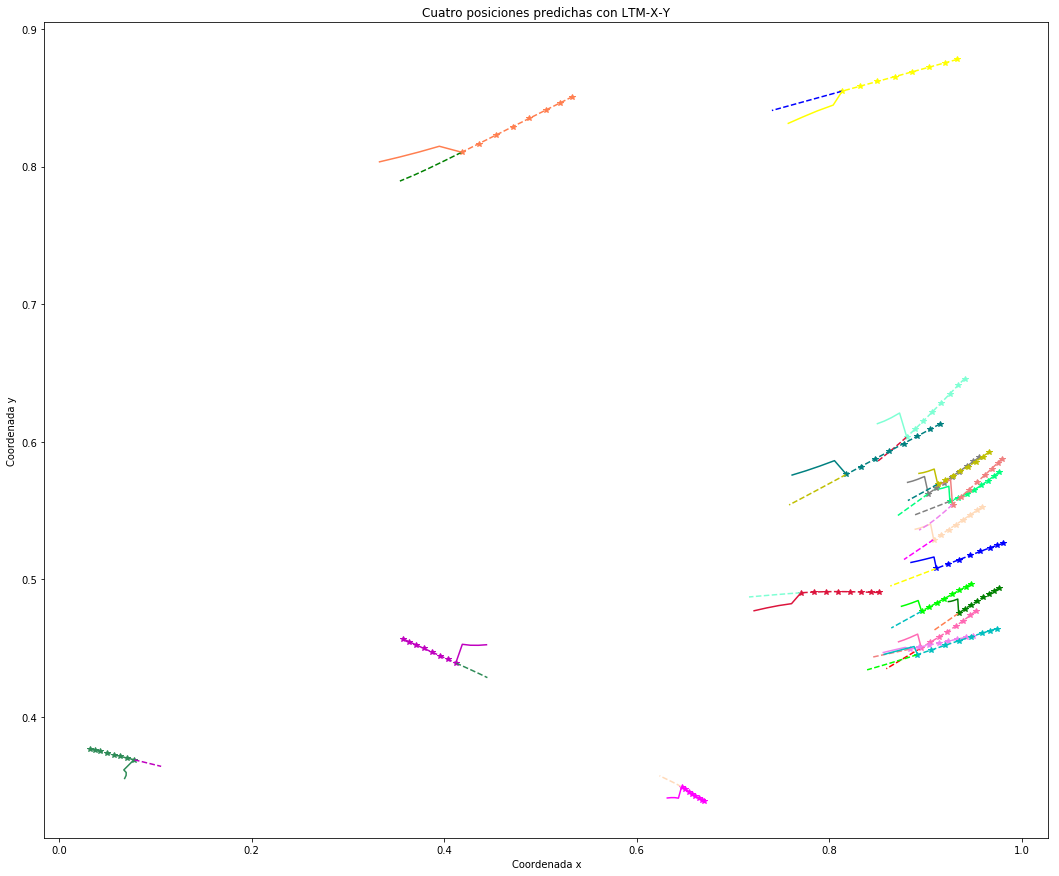

In [36]:
sample_x_persona_normalizado(datos,8,4)

In [39]:
def sample_x_persona_pixeles(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15))  
    color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    todo=[]
    print(len(X))
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modelxy.predict(traj_obsr)
            next_point = predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
    
    
        traj_pre =  np.column_stack((768*traj_pred[:,0],576*traj_pred[:,1]))
        traj_tr = np.column_stack((768*Y_true[i][:,0],576*Y_true[i][:,1]))
       
        
        diff = traj_tr[seq_length_obs:]-traj_pre[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
        error_prom = error_promedio(traj_pre , traj_tr, seq_length_obs)
        FDE = error_desplazamiento_final(traj_pre , traj_tr)
        
    

        print("TRAYECTORIA PREDICHA DEL PEATON ",i+1)
        print(traj_pre)
        print("TRAYECTORIA VERDADERA  ")
        print(traj_tr)
        print("EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        #cpu = random.choice(range(17))
                         
        subplot(1,1,1)
        
        # observado
        predicha = plt.plot(traj_tr[:seq_length_obs,0],traj_tr[:seq_length_obs,1],'*--',color=color_names[19-i])
        # Grand Truth
        predicha = plt.plot(traj_tr[seq_length_obs-1:,0],traj_tr[seq_length_obs-1:,1],'--',color=color_names[i])
        # Predicho
        predicha = plt.plot(traj_pre[seq_length_obs-1:,0],traj_pre[seq_length_obs-1:,1],'-',color=color_names[19-i])
        
        plt.title("Cuatro posiciones predichas de PETS con LSTM-DX-DY") 
        plt.xlabel('Coordenada x')
        plt.ylabel('Coordenada y')
        
        
        total_error += error_prom
    error_modelo = total_error/len(X)
    ade=[t for o in todo for t in o]
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print('Error ADE')
    print(np.mean(ade))
    #plt.savefig("trayectoriasdxdy_pixel.pdf")
    plt.show()
    


19
('TRAYECTORIA PREDICHA DEL PEATON ', 1)
[[731.5149     274.8085    ]
 [727.0758     272.93      ]
 [721.5397     270.7047    ]
 [715.2923     268.3596    ]
 [708.6437     266.0343    ]
 [701.7908     263.7643    ]
 [694.8595     261.5389    ]
 [687.897      259.3316    ]
 [685.01829529 265.0357933 ]
 [679.09844971 263.65254593]
 [674.18916321 262.62129021]
 [669.77806091 261.82509041]]
TRAYECTORIA VERDADERA  
[[731.5149 274.8085]
 [727.0758 272.93  ]
 [721.5397 270.7047]
 [715.2923 268.3596]
 [708.6437 266.0343]
 [701.7908 263.7643]
 [694.8595 261.5389]
 [687.897  259.3316]
 [680.925  257.13  ]
 [673.953  254.9284]
 [666.9848 252.7316]
 [660.0282 250.5522]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 11.543 
ERROR DE DESPLAZAMIENTO FINAL ES =14.904
('TRAYECTORIA PREDICHA DEL PEATON ', 2)
[[722.5286     372.0656    ]
 [717.2875     369.2159    ]
 [710.8914     365.7386    ]
 [703.8897     361.9388    ]
 [696.7009     358.06      ]
 [689.5906     354.2819    ]
 [682.7586     350

('TRAYECTORIA PREDICHA DEL PEATON ', 17)
[[752.9886     302.989     ]
 [748.5203     302.2501    ]
 [742.4895     301.1371    ]
 [735.1748     299.6876    ]
 [726.9552     298.0089    ]
 [718.1868     296.2151    ]
 [709.1455     294.3811    ]
 [699.9851     292.5376    ]
 [698.06291199 297.3234787 ]
 [690.68449402 296.35445023]
 [684.83692932 295.62732697]
 [679.72572327 295.04340363]]
TRAYECTORIA VERDADERA  
[[752.9886 302.989 ]
 [748.5203 302.2501]
 [742.4895 301.1371]
 [735.1748 299.6876]
 [726.9552 298.0089]
 [718.1868 296.2151]
 [709.1455 294.3811]
 [699.9851 292.5376]
 [690.7902 290.6961]
 [681.5855 288.8557]
 [672.3809 287.0156]
 [663.1764 285.1753]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 14.010 
ERROR DE DESPLAZAMIENTO FINAL ES =19.268
('TRAYECTORIA PREDICHA DEL PEATON ', 18)
[[749.8606     284.3121    ]
 [746.3134     283.2322    ]
 [741.9887     281.9059    ]
 [737.2536     280.4295    ]
 [732.3726     278.8623    ]
 [727.4717     277.2264    ]
 [722.5996     275.

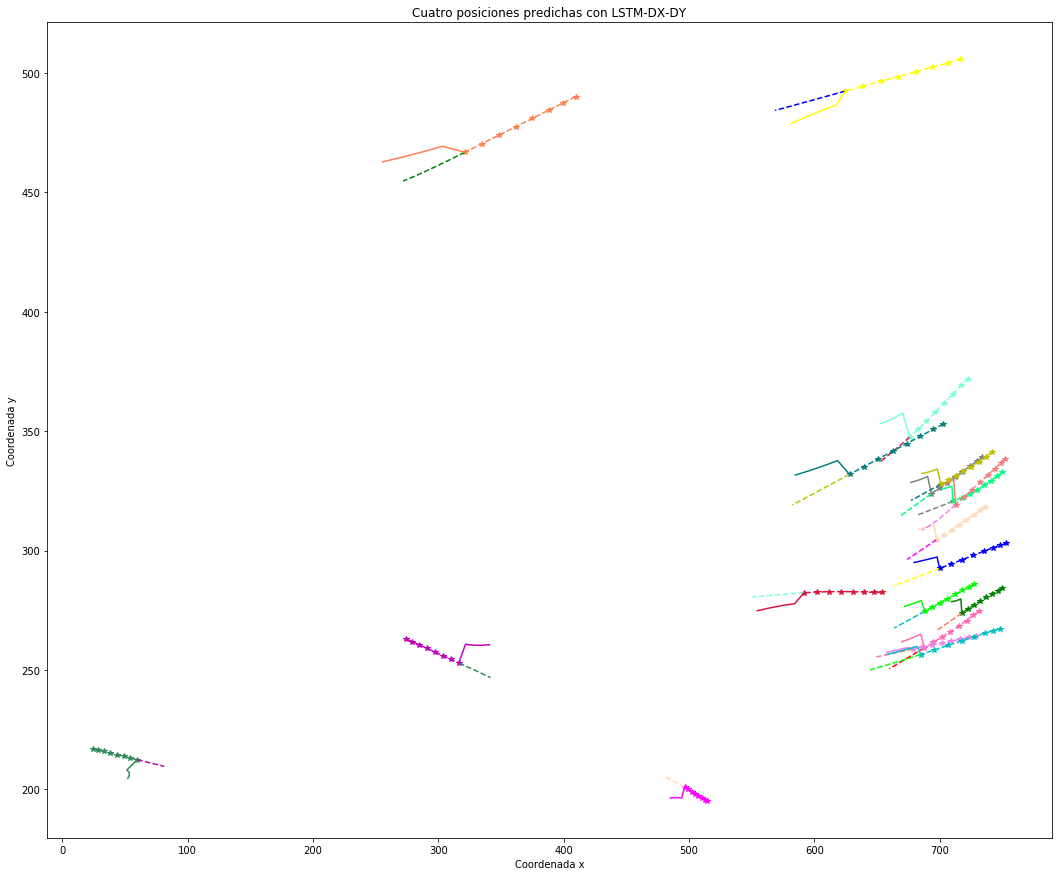

In [40]:
sample_x_persona_pixeles(datos,8,4)

## Trayectorias para la evaluacion cualitativa

In [41]:
cruce = []
cruce.append(datos[3][252:264,:])
cruce.append(datos[4][135:147,:])

paralelos = []
paralelos.append(datos[2][1:13])
paralelos.append(datos[3][20:32])

inverso = []
inverso.append(datos[4][167:179])
inverso.append(datos[6][15:27])


In [42]:
paralelos[0]

array([[0.52075065, 0.84638715],
       [0.50538112, 0.84099028],
       [0.48851432, 0.83506858],
       [0.47105456, 0.82893993],
       [0.4534224 , 0.82275243],
       [0.43579076, 0.8165658 ],
       [0.41822422, 0.81041771],
       [0.40087982, 0.80440174],
       [0.38409583, 0.7987217 ],
       [0.3683513 , 0.79366649],
       [0.3540224 , 0.78946319],
       [0.34110898, 0.78611163]])

In [43]:
def grafica(p,v,name):
    color_names = ["r", "g", "b","c","m","y", "peachpuff","grey", "fuchsia","violet",
                   "teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    
    plot(p[0][0:8,0],p[0][0:8,1],'*--',color= color_names[2],label = 'Observed')
    plot(p[0][7:,0],p[0][7:,1],'-',color=color_names[2],label='Predicted')
    plot(v[0][7:,0],v[0][7:,1],'--',color=color_names[4],label='Ground truth')
    
    plot(p[1][0:8,0],p[1][0:8,1],'*--',color= color_names[2])
    plot(p[1][7:,0],p[1][7:,1],'-',color=color_names[2])
    plot(v[1][7:,0],v[1][7:,1],'--',color=color_names[4])
    
    plt.legend()
    plt.savefig(name)
    plt.show()

In [44]:
# Esta funcion hace la prediccion en coordenadas pixel
def sample_en_pixeles_cualitativamente(datos, seq_length_obs, seq_length_pred):
    
    
    X,Y_true = secuencia_pred(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo = []
    trayectoria = []
    verdadero= []
    
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modelxy.predict(traj_obsr)
            next_point = predict
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)], next_point), axis = 0)
            traj_pred = np.concatenate((traj_pred, next_point), axis = 0)
        
        traj_pre =  np.column_stack((768*traj_pred[:,0],576*traj_pred[:,1]))
        traj_tr = np.column_stack((768*Y_true[i][:,0],576*Y_true[i][:,1]))
       
        trayectoria.append(traj_pre)
        verdadero.append(traj_tr)
        #SE CALCULA LA METRICA ADE 
        diff = traj_pre[seq_length_obs:]-traj_tr[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        total_error += error_promedio(traj_pre , traj_tr, seq_length_obs)
        total_final += error_desplazamiento_final(traj_pre, traj_tr)
            
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    
    ade = [t for o in todo for t in o]
    
    print('---------Error--------')
    print('ADE')
    print(np.mean(ade))
    
    print('Error promedio')
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
    return trayectoria, verdadero

---------Error--------
ADE
7.01093724414237
Error promedio
7.01093724414237
FDE
8.539814251143598


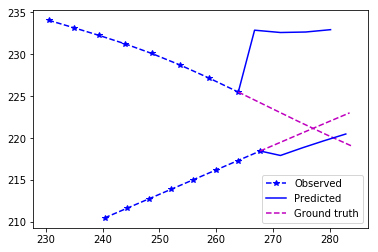

In [45]:
"""
Para graficar los resultados cualitativos se escoge el mejor modelo de los 
5,  para pets con framerate 7.5
"""
modelxy = load_model('lstm-xy3.h5')
band = 0
if(band==0):
    p,v = sample_en_pixeles_cualitativamente(cruce,8,4)
    name = "cruce_absoluto_ing.pdf"
elif(band==1):
    p,v = sample_en_pixeles_cualitativamente(paralelos,8,4)
    name = "paralelos_absoluto_ing.pdf"
else:
    p,v = sample_en_pixeles_cualitativamente(inverso,8,4)
    name = "inverso_absoluto_ing.pdf"
grafica(p,v,name)